##### 숫자 손글씨 데이터셋 활용한 분류용   신경망 모델 구현
- 데이터셋 : Tensorflow 저장소에서 제공하는 mnist.npz 사용
- 데이터 피쳐   : (28, 28) 크기의 이미지 데이터 
    * 학습용    : 60000장
    * 테스트용  : 10000장
- 데이터 라벨   : 0~ 9, 10개 숫자 분류
- 학습 방법     : 지도 학습 > 분류 > 다중 분류
- 알고리즘      : 신경망 기반 알고리즘 문제 해결

[1] 모듈 로딩 및 데이터 준비

In [15]:
### 모듈 로딩
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
import matplotlib.pyplot as plt

# Initializing libiomp5md.dll, but found libiomp5md.dll already initialized
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [16]:
### 데이터 준비
(X_train, y_train), (X_test, y_test) = load_data()

print(f'X_train : {X_train.shape} y_train : {y_train.shape}')
print(f'X_test : {X_test.shape} y_test : {y_test.shape}')

X_train : (60000, 28, 28) y_train : (60000,)
X_test : (10000, 28, 28) y_test : (10000,)


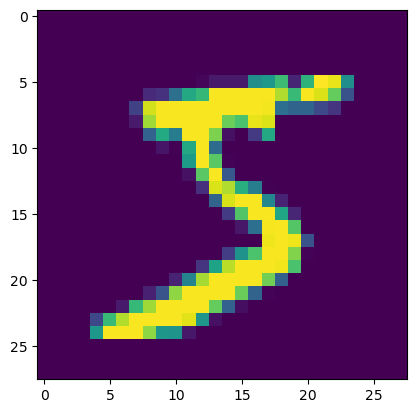

In [17]:
plt.imshow(X_train[0])
plt.show()

[2] 데이터 전처리 <hr>
- 피쳐
    * 2D (28,28) -> 1D 형태 변형
    * 값 : 0 ~ 255 -> 정규화 0.0 ~ 1.0
- 라벨
    * 값 : 정수형 (0 ~ 9) -> 0과 1로 구성된 one-hot Encoding
        - 0 : 1 0 0 0 0 0 0 0 0 0
        - 1 : 0 1 0 0 0 0 0 0 0 0
        ...
        - 9 : 0 0 0 0 0 0 0 0 0 1

In [18]:
### 피쳐에 대한 전처리
#X_train.dtype, X_train/255, (X_train/255).dtype

###[1] 값을 0 ~ 1 정규화 
X_train = (X_train/255.)
print(f'x_max : {X_train.max()} , x_min : {X_train.min()}')

x_max : 1.0 , x_min : 0.0


In [19]:
### [2] 데이터 타입 float64 -> float32 변경
X_train, X_test = X_train.astype('float32'), X_test.astype('float32')

In [20]:
### [3] 2D -> 1D 변형 : 전결합층 (Full-Connected Layer)에 전달하기 위해
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784]) # -1 배열의 크기를 자동으로 계산

print(f'X_train shape : {X_train.shape}, x_test shape : {X_test.shape}')

X_train shape : (60000, 784), x_test shape : (10000, 784)


In [21]:
### 라벨에 대한 전처리------------------------------------
## One-Hot 인코딩
y_train, y_test = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10)

print(f'y_train shape : {y_train.shape}, y_test shape : {y_test.shape}')


y_train shape : (60000, 10), y_test shape : (10000, 10)


In [22]:
## 인코딩 결과 확인
y_train[:30]

<tf.Tensor: shape=(30, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0.,

[3] 모델 클래스 설계 <hr>
- 입력층 : 입력 784개, 출력 10개 (즉, 퍼셉트론이 10개)
- 은닉층 : 입력 10개, 출력 20개 (즉, 퍼셉트론이 20개)
- 출력충 : 입력 20개, 출력 10개 (즉, 라벨 수)

In [23]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):   # **kwargs : 0개 ~ N개 매개변수  키=값의 형태 
    # 부모생성  
    super().__init__(**kwargs)
    # 초기 W, b 설정
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  # 학습 처리 메서드 => 가중치*피쳐 + 절편
  def __call__(self, x):
    return self.w * x + self.b

In [24]:
class DenseLayer(tf.Module):
    def __init__(self, input_nums, out_nums):
        super().__init__()
        self.W = tf.Variable(tf.random.normal((input_nums, out_nums)))
        self.b = tf.Variable(tf.zeros((out_nums)))
    
    def __call__(self, input):
        wbsum = tf.matmul(input, self.W) + self.b

        return wbsum

In [25]:
class SequenceLayer(tf.Module):
    #인스턴스 생성 메서드
    def __init__(self, in_in, in_out, hd_out, out_out, kind='reg'):
        super().__init__()
        self.kind = kind
        
        #입력층 : 피쳐개수, 퍼셉트론개수
        self.in_layer = DenseLayer(in_in, in_out)

        #은닉층 : 피쳐개수, 퍼셉트론개수
        self.hd_layer = DenseLayer(in_out, hd_out)
        
        #출력층 : 피쳐개수, 타켓개수
        self.out_layer = DenseLayer(hd_out,out_out)

    # 순방향/전방향 학습 메서드
    def __call__(self, data):
        #입력층 학습
        wbsum = self.in_layer(data)
        output = tf.nn.relu(wbsum)

        #은닉층 학습
        wbsum = self.hd_layer(output)
        output = tf.nn.relu(wbsum)

        #출력층 학습
        if self.kind=='reg':
            return self.out_layer(output)
        elif self.kind == 'binary':
            return tf.nn.sigmoid(self.out_layer(output))
        elif self.kind == 'multi':
            return tf.nn.softmax(self.out_layer(output))
        else:
            return 'unknown'

In [26]:
mnistModel = SequenceLayer(784, 10, 20, 10, 'multi')